In [1]:
# Imports
from utils import *

# Suppress warnings - https://stackoverflow.com/questions/53784971/how-to-disable-convergencewarning-using-sklearn
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

Data Ingestion

In [2]:
base_path = os.getcwd()
path = os.path.join(base_path , 'Fortune 500 2017 - Fortune 500.csv')
frt_500 = pd.read_csv(path)
# Rank seems to be pretty useless - it is based on Revenue 
frt_500 = frt_500.drop('Rank' , axis = 1)

Feature Engg

In [3]:
def feature_engg_chain(data_0,target_0,scaler):
    '''
    perform feature engg and return df of independent vars and dependent vars
    params: data_0 -> input dataframe w/o target var
    params: target_0 -> target var/ dependent var
    params: scaler -> sklearn scaler object
    returns: data_sd -> dataframe containing standardized numerical values and unstandardized categorical values (encoded as numbers) and standardized dependent variable 
    '''

    # Some transformations
    # 1. HQZIP shouldn't be int64 - it is a categorical variable
    data = data_0.copy()
    data['Hqzip'] = data['Hqzip'].astype('str').str.zfill(5)
    # 2. Prftchange shouldn't be an object - it is a float. However it needs to be preprocessed - there are some commas etc
    try:
        data['Prftchange'] = data['Prftchange'].astype('float')
    except:
        data['Prftchange'] = data['Prftchange'].apply(lambda x : x.replace(',',''))
        data['Prftchange'] = data['Prftchange'].astype('float')
    
    # Does Geography play a role?
    # Can we encode zip into lat-long info?
    nomi = pgeocode.Nominatim('us')
    data['lat'] = data['Hqzip'].apply(lambda x: nomi.query_postal_code(x).latitude)
    data['long'] = data['Hqzip'].apply(lambda x: nomi.query_postal_code(x).longitude) 

    num_cov = list(data.describe().columns)
    cat_cov = list(data.describe(include = 'object').columns)

    num_data = data.loc[: , num_cov]
    cat_data = data.loc[: , cat_cov]

    # cat_data also has some info in it that may be useful in predicting rev / clustering. Let's label encode them.
    le_1 = LabelEncoder()
    le_2 = LabelEncoder()

    l_encoded_sector = le_1.fit_transform(cat_data.Sector)
    l_encoded_industry = le_2.fit_transform(cat_data.Industry)

    # Remove multicollinearity
    num_data['Profits_per_asset'] = num_data['Profits']/num_data['Assets'] # profit per asset
    num_data['Totshequity_per_asset'] = num_data['Totshequity']/num_data['Assets'] # Totshequity per asset
    num_data.drop(['Profits' , 'Totshequity'] , axis = 1 , inplace = True)
    
    # Scaling independent vars
    num_data_sd = pd.DataFrame(scaler.fit_transform(num_data) , columns = num_data.columns)

    X_sd = pd.concat([
        num_data_sd,
        pd.Series(l_encoded_sector , name = 'sector') , 
        pd.Series(l_encoded_industry , name = 'industry')
    ], axis=1).reset_index().drop('index',axis = 1) # otherwise some nans are introduced due to concat. not fully reproducible yet 
    
    target_sd = pd.DataFrame(np.log10(target_0), columns = ["Revenues"]).reset_index().drop('index',axis = 1) # otherwise some nans are introduced due to concat. not fully reproducible yet
    data_sd = pd.concat([X_sd , target_sd], axis = 1)
    return data_sd

In [4]:
# Creating a scaler
feature_sc = StandardScaler()

# Applying feature engg chain to data
data_sd = feature_engg_chain(
    frt_500[[col for col in frt_500 if col!="Revenues"]], 
    frt_500.Revenues, 
    scaler=feature_sc
    )

In [5]:
#Check
data_sd.isnull().sum()

Employees                0
Revchange                0
Prftchange               0
Assets                   0
lat                      0
long                     0
Profits_per_asset        0
Totshequity_per_asset    0
sector                   0
industry                 0
Revenues                 0
dtype: int64

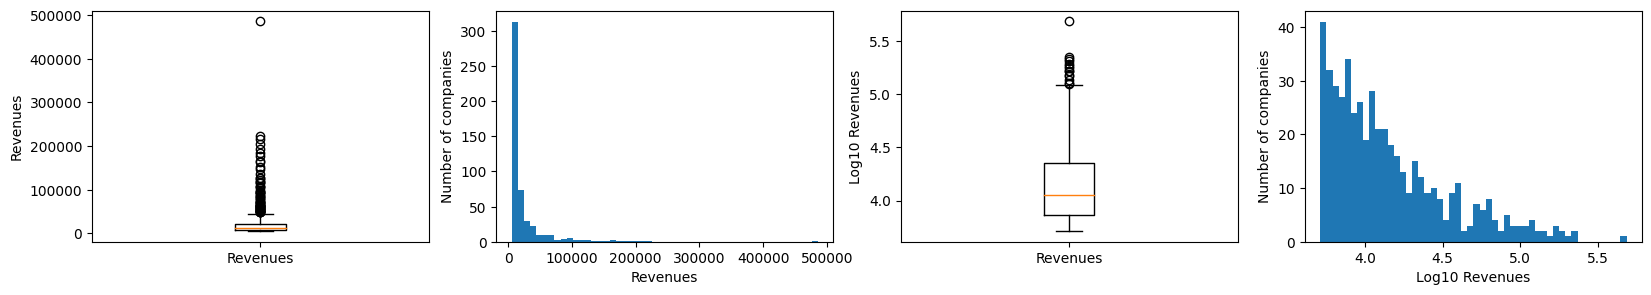

In [6]:
# Distribution of Revenue/ Logged distribution of Revenue
fig, ax = plt.subplots(1,4 , figsize = (20,3))

ax[0].boxplot(frt_500.Revenues);
ax[0].set_xticklabels(['Revenues']);
ax[0].set_ylabel('Revenues');

ax[1].hist(frt_500.Revenues , bins = 50)
ax[1].set_xlabel('Revenues');
ax[1].set_ylabel('Number of companies');

ax[2].boxplot(np.log10(frt_500.Revenues));
ax[2].set_xticklabels(['Revenues']);
ax[2].set_ylabel('Log10 Revenues');

ax[3].hist(np.log10(frt_500.Revenues) , bins = 50)
ax[3].set_xlabel('Log10 Revenues');
ax[3].set_ylabel('Number of companies');

### **Clustering**

In [7]:
# Use PCA to project data onto two dimensions
n = 2
pca = PCA(n_components=n)
prin_comp = pca.fit_transform(data_sd)
prin_comp_df = pd.DataFrame(prin_comp , columns = ['PC'+str(comp) for comp in range(1,n+1)])
print(prin_comp.shape , pca.explained_variance_ratio_ , sum(pca.explained_variance_ratio_)) # about 98% var is explained. great

(500, 2) [0.92257899 0.06093741] 0.983516396955755


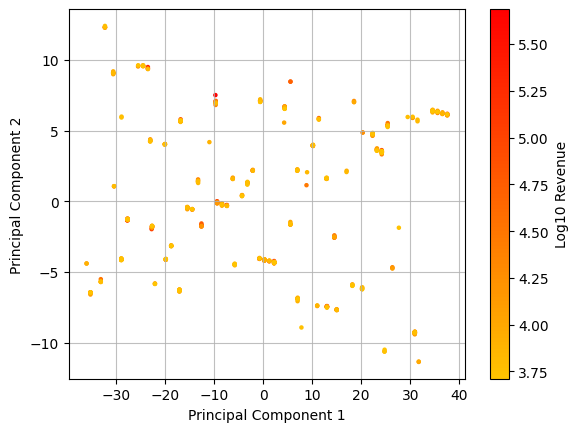

In [8]:
cmap = LinearSegmentedColormap.from_list('custom blue', [(0,'#ffc400'),(1,'#ff0000')], N=100)

fig , ax = plt.subplots()

ax1 = ax.scatter(prin_comp_df.PC1 , prin_comp_df.PC2 , c = data_sd['Revenues'] , s = 5, cmap=cmap)
ax.grid(alpha = 0.8);
# ax.set_xscale('log');
ax.set_xlabel('Principal Component 1')

# ax.set_yscale('log');
ax.set_ylabel('Principal Component 2');

cbar = fig.colorbar(ax1)
cbar.set_label('Log10 Revenue')

In [9]:
# Scale Features before clustering
prin_comp_scaler = StandardScaler()
scaled_features = prin_comp_scaler.fit_transform(prin_comp_df)

DBSCAN

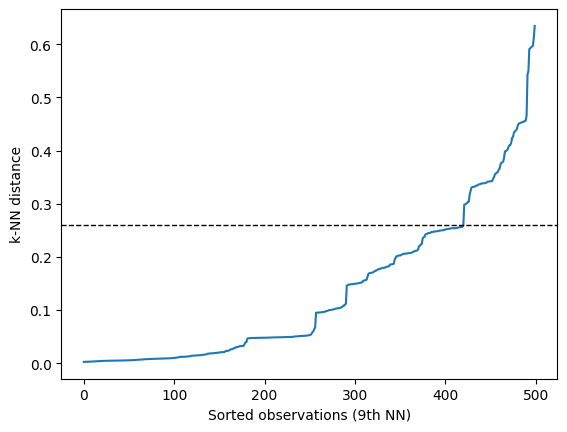

In [10]:
# Find optimal epsilon - adapted from http://www.sefidian.com/2020/12/18/how-to-determine-epsilon-and-minpts-parameters-of-dbscan-clustering/ 
n = 10
neighbours = NearestNeighbors(n_neighbors=n)
neighbours_fit = neighbours.fit(scaled_features)
# Find the k-neighbors of a point
neighbours_dist, _ = neighbours.kneighbors(scaled_features)

k_dist = np.sort(neighbours_dist[: , n-1])

plt.plot(k_dist)
plt.axhline(y=0.26, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance")
plt.xlabel(f"Sorted observations ({n-1}th NN)")
plt.show()

In [11]:
clusters = DBSCAN(eps=0.26, min_samples=10).fit(scaled_features)
# get cluster population
counted = Counter(clusters.labels_)
#get number of outliers
counted.get(-1)

70

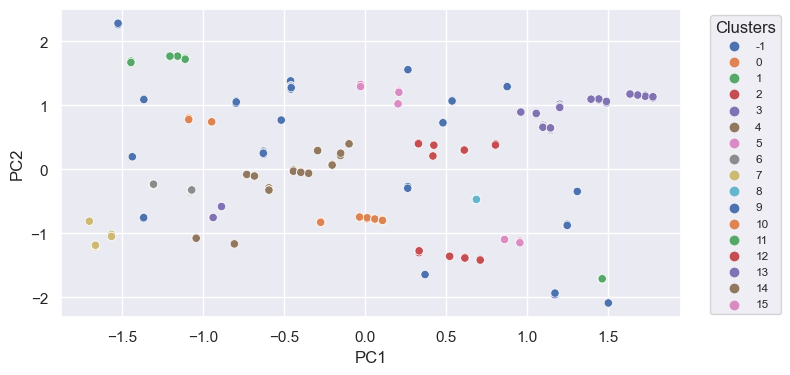

In [12]:
# Plot clusters
sns.set(rc={'figure.figsize':(8,4),'legend.fontsize':8.5})
p = sns.scatterplot(data=pd.DataFrame(scaled_features ,columns = ["PC1","PC2"]), x="PC1", y="PC2", hue=clusters.labels_, legend="full", palette="deep")
sns.move_legend(p, "upper right", bbox_to_anchor=(1.17, 1), title='Clusters')
plt.show()

In [13]:
# Grid Search through DBSCAN params
min_samples = [5,10,20,25,30,50]
eps = [0.01,0.05,0.1,0.25,0.4]

outliers = {}

import itertools
for samples , eps in itertools.product(min_samples,eps):
    clusters = DBSCAN(eps=eps, min_samples=samples).fit(scaled_features)
    # get cluster population
    counted = Counter(clusters.labels_)
    outliers[(samples,eps)] = counted.get(-1)

# Combination with least outliers
print(combo := min(outliers , key = outliers.get))
samples , eps = combo

(5, 0.4)


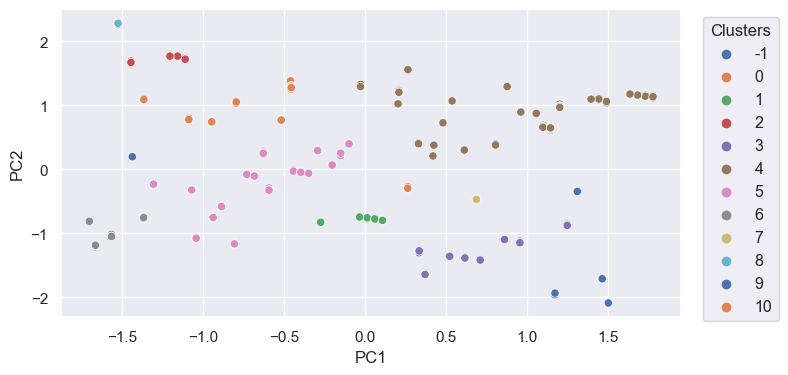

In [14]:
# Fit with best params
clusters = DBSCAN(eps=eps, min_samples=samples).fit(scaled_features)
# get cluster population
counted = Counter(clusters.labels_)

sns.set(rc={'figure.figsize':(8,4),'legend.fontsize':11.5})
p = sns.scatterplot(data=pd.DataFrame(scaled_features ,columns = ["PC1","PC2"]), x="PC1", y="PC2", hue=clusters.labels_, legend="full", palette="deep")
sns.move_legend(p, "upper right", bbox_to_anchor=(1.17, 1), title='Clusters')
plt.show()

K-Means

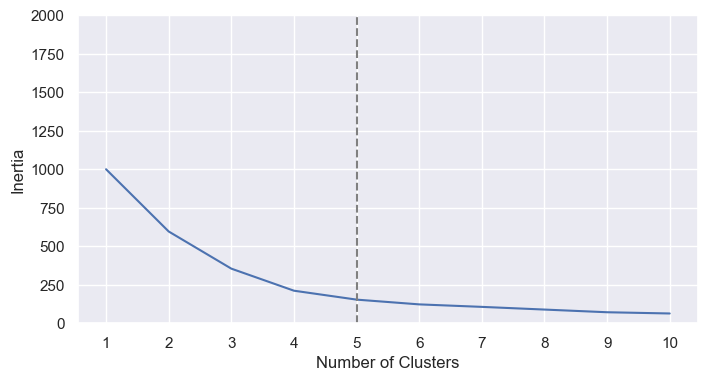

In [15]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"max_iter": 300,
"random_state": SEED,
}

# A list holds the SSE values for each k from 1 to 10
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.vlines(5, ymin = 0, ymax = 2000 , ls = '--' , color = 'gray');
plt.ylim(0,2000);
plt.show()

         cluster
cluster         
0            123
1             69
2             93
3            144
4             71


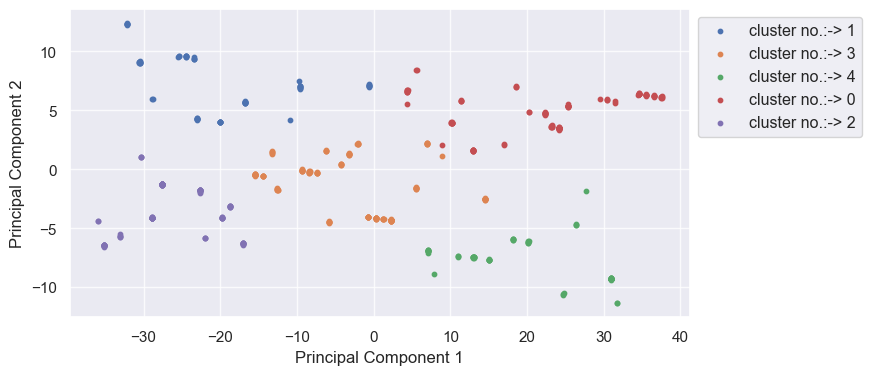

In [16]:
# Fitting with optimal number of clusters
kmeans = KMeans(
init="random",
n_clusters=5,
n_init=10,
max_iter=300,
random_state=SEED
)

kmeans.fit(scaled_features)

labels = kmeans.labels_

prin_comp_df['cluster'] = labels
print(prin_comp_df.groupby('cluster').agg({'cluster':'count'}))

fig , ax = plt.subplots()

for cluster in prin_comp_df.cluster.unique():
    df = prin_comp_df[
        prin_comp_df['cluster'] == cluster
    ]

    ax.scatter(df.PC1 , df.PC2 , label = f'cluster no.:-> {cluster}' , s = 10)
    ax.legend(loc = 'best')
    ax.grid(alpha = 0.8);
    # ax.set_xscale('log');
    ax.set_xlabel('Principal Component 1')

    # ax.set_yscale('log');
    ax.set_ylabel('Principal Component 2');

plt.legend(loc = 'best', bbox_to_anchor = (1,1));

### **Cluster Profiling**

In [17]:
# Inverse Transforms
num_cov = ['Employees','Revchange','Prftchange','Assets','lat','long','Profits_per_asset','Totshequity_per_asset']
num_data = pd.DataFrame(feature_sc.inverse_transform(data_sd[num_cov]) , columns = num_cov)

y = 10**(data_sd.Revenues)

sector_industry = data_sd[['sector','industry']]

data_clustered = pd.concat(
    [
        frt_500.Title,
        frt_500.Sector,
        num_data,
        sector_industry,
        pd.Series(labels, name='cluster'),
        y
    ],
    axis = 1
)

In [18]:
# Get a look at industries across clusters
data_clustered.groupby(
    [
        'cluster',
        'Sector'
        ]
    ).agg({'Title':'count'}).reset_index().pivot_table(
    index = 'Sector' , columns = 'cluster').fillna(0)

Title                        
cluster                           0     1     2     3     4
Sector                                                     
Aerospace & Defense             0.0   0.0  12.0   0.0   0.0
Apparel                         0.0   0.0   5.0   0.0   0.0
Business Services               0.0   0.0  14.0   0.0   6.0
Chemicals                       0.0   0.0  14.0   0.0   0.0
Energy                          0.0   0.0   7.0   0.0  50.0
Engineering & Construction      0.0   0.0   7.0   6.0   0.0
Financials                      0.0   0.0  31.0  42.0  11.0
Food & Drug Stores              0.0   0.0   0.0   7.0   0.0
Food, Beverages & Tobacco       0.0   0.0   3.0  18.0   3.0
Health Care                     0.0   0.0   0.0  38.0   0.0
Hotels, Restaurants & Leisure   0.0   0.0   0.0  10.0   0.0
Household Products              0.0   0.0   0.0  11.0   1.0
Industrials                     0.0  13.0   0.0   6.0   0.0
Materials                      10.0   3.0   0.0   6.0   0.0
Media                           2.0   9.0   0.0   0.0   0.0
Motor Vehicles & Parts          9.0   0.0   0.0   0.0   0.0
Retailing                      29.0  18.0   0.0   0.0   0.0
Technology                     23.0  20.0   0.0   0.0   0.0
Telecommunications             10.0   0.0   0.0   0.0   0.0
Transportation                 11.0   6.0   0.0   0.0   0.0
Wholesalers                    29.0   0.0   0.0   0.0   0.0

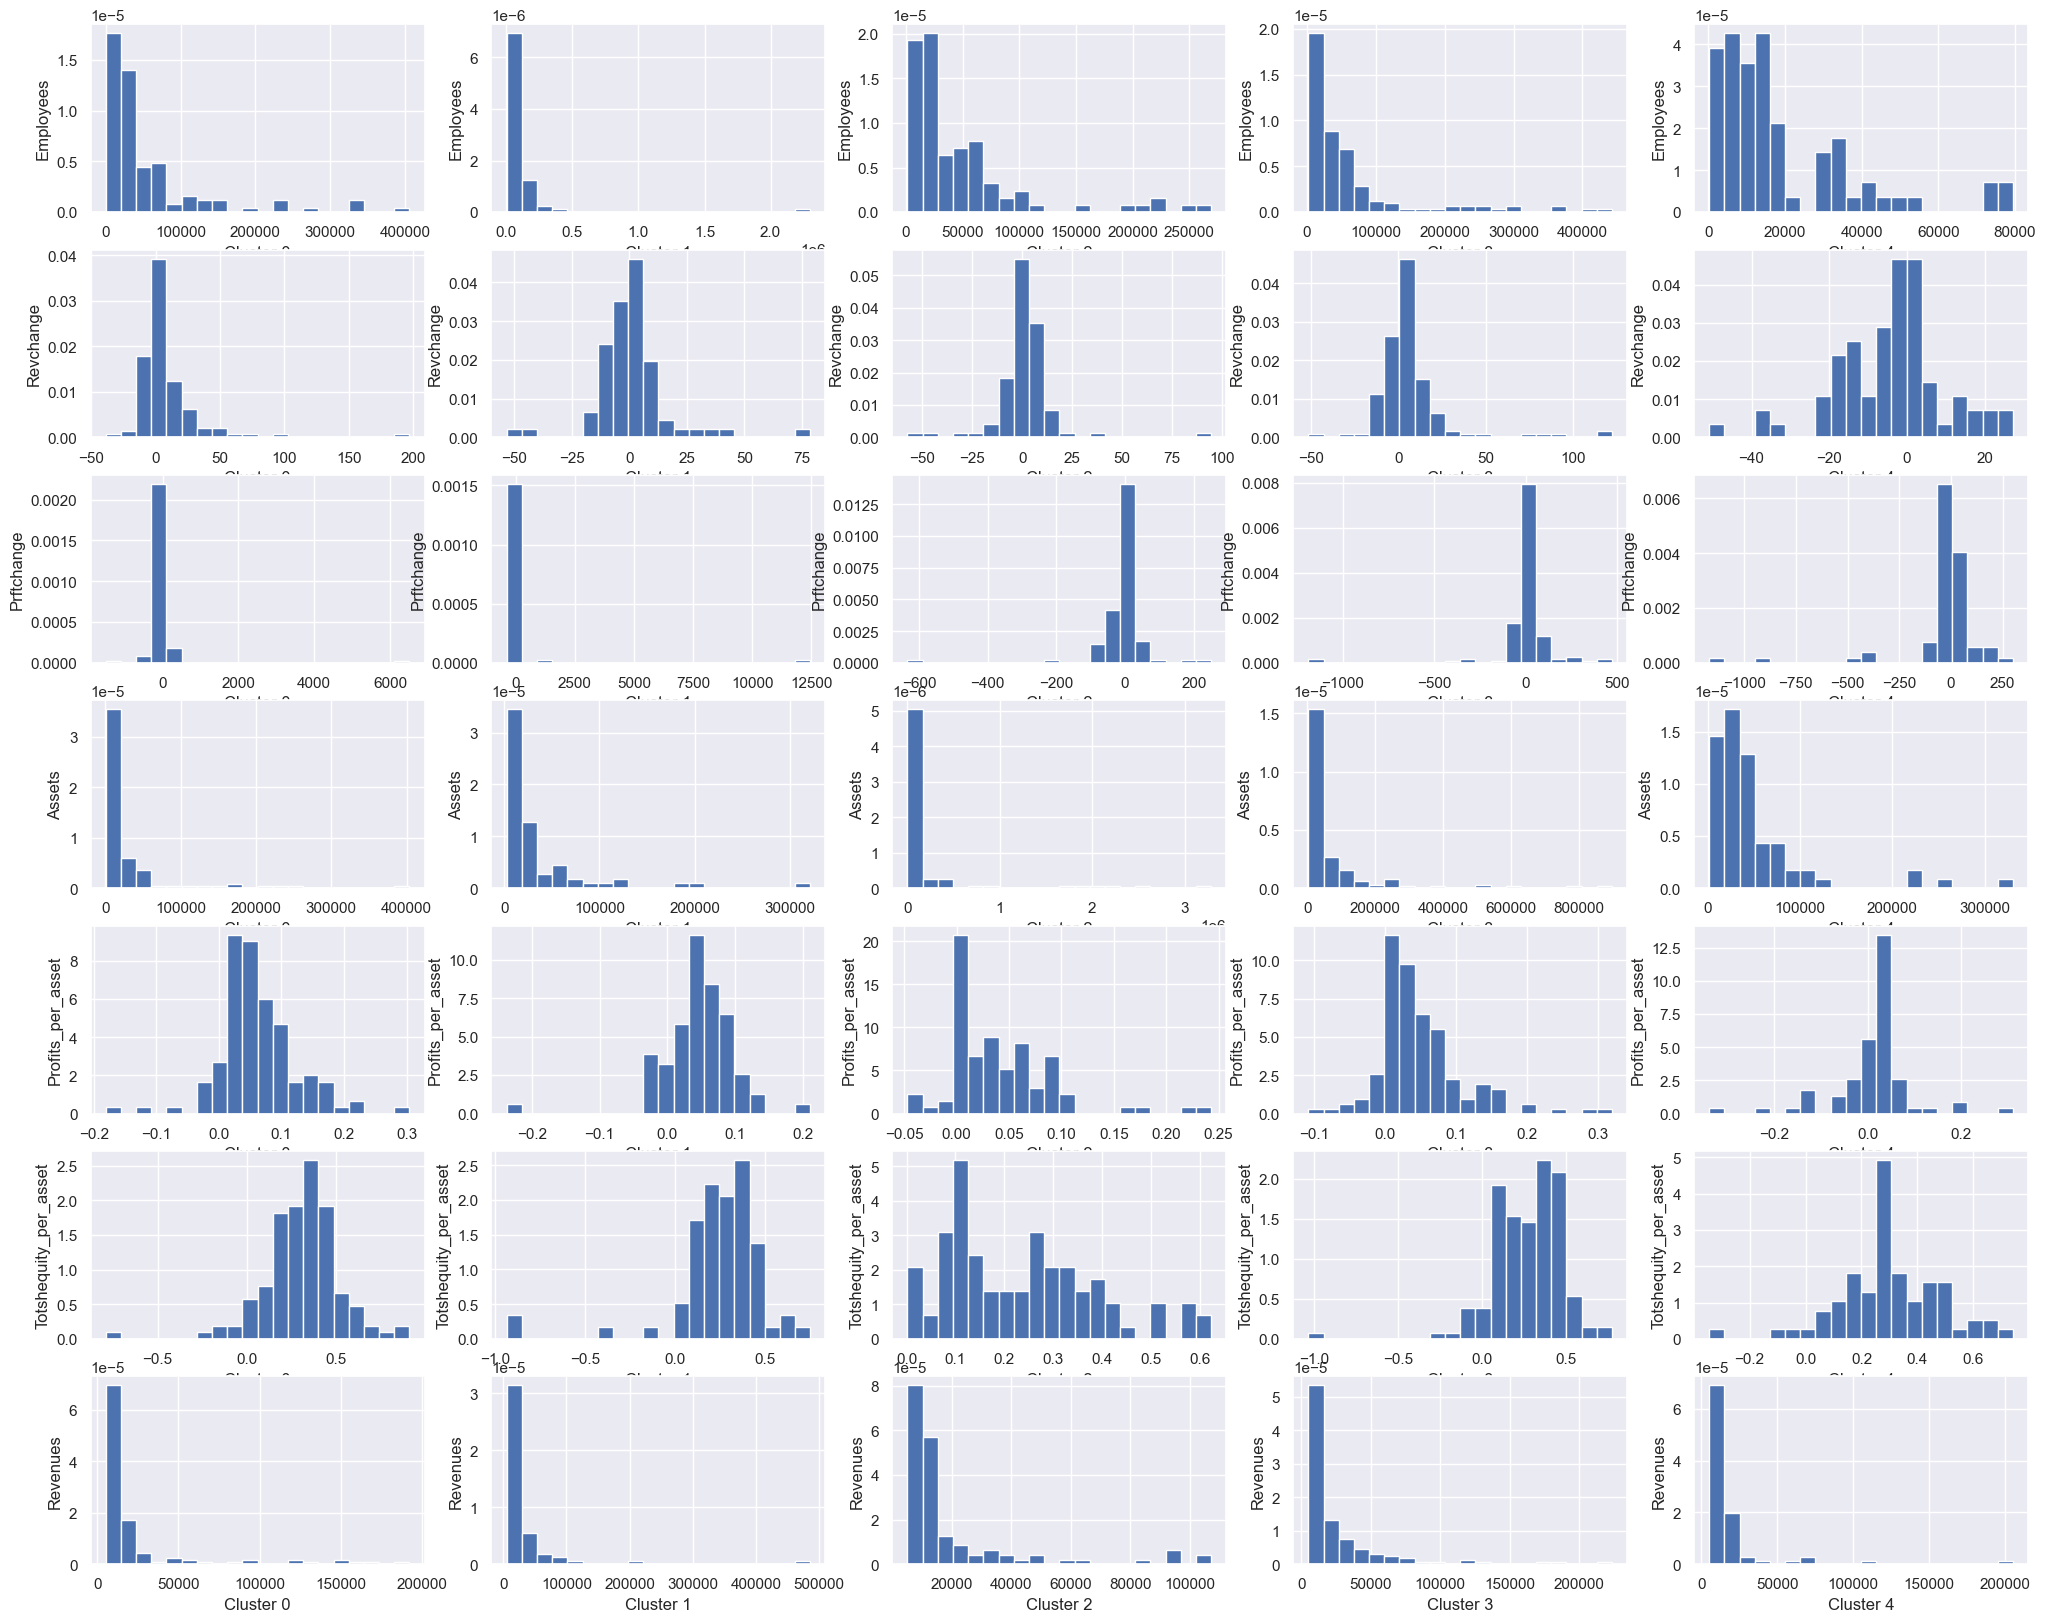

In [19]:
# cluster-wise covariate histogram
numeric_cols = ['Employees', 'Revchange', 'Prftchange', 'Assets', 'Profits_per_asset', 'Totshequity_per_asset', 'Revenues']

fig, ax = plt.subplots(len(numeric_cols), data_clustered.cluster.nunique() , figsize = (25,20))

for row_idx, row in enumerate(numeric_cols):
    for cluster in data_clustered.cluster.unique():
        ax[row_idx][cluster].hist(data_clustered[data_clustered['cluster'] == cluster][row] , bins = 20, density=True)
        ax[row_idx][cluster].set_xlabel(f'Cluster {cluster}')
        ax[row_idx][cluster].set_ylabel(f'{row}')

### **Regression**

In [20]:
frt_500 = pd.concat([
    frt_500,
    pd.Series(labels, name='cluster')
] , axis = 1)

# Cast out outlier (Walmart)
frt_500 = frt_500[frt_500['Title']!="Walmart"]

X = frt_500[[col for col in frt_500.columns if col!="Revenues"]]
y = frt_500["Revenues"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

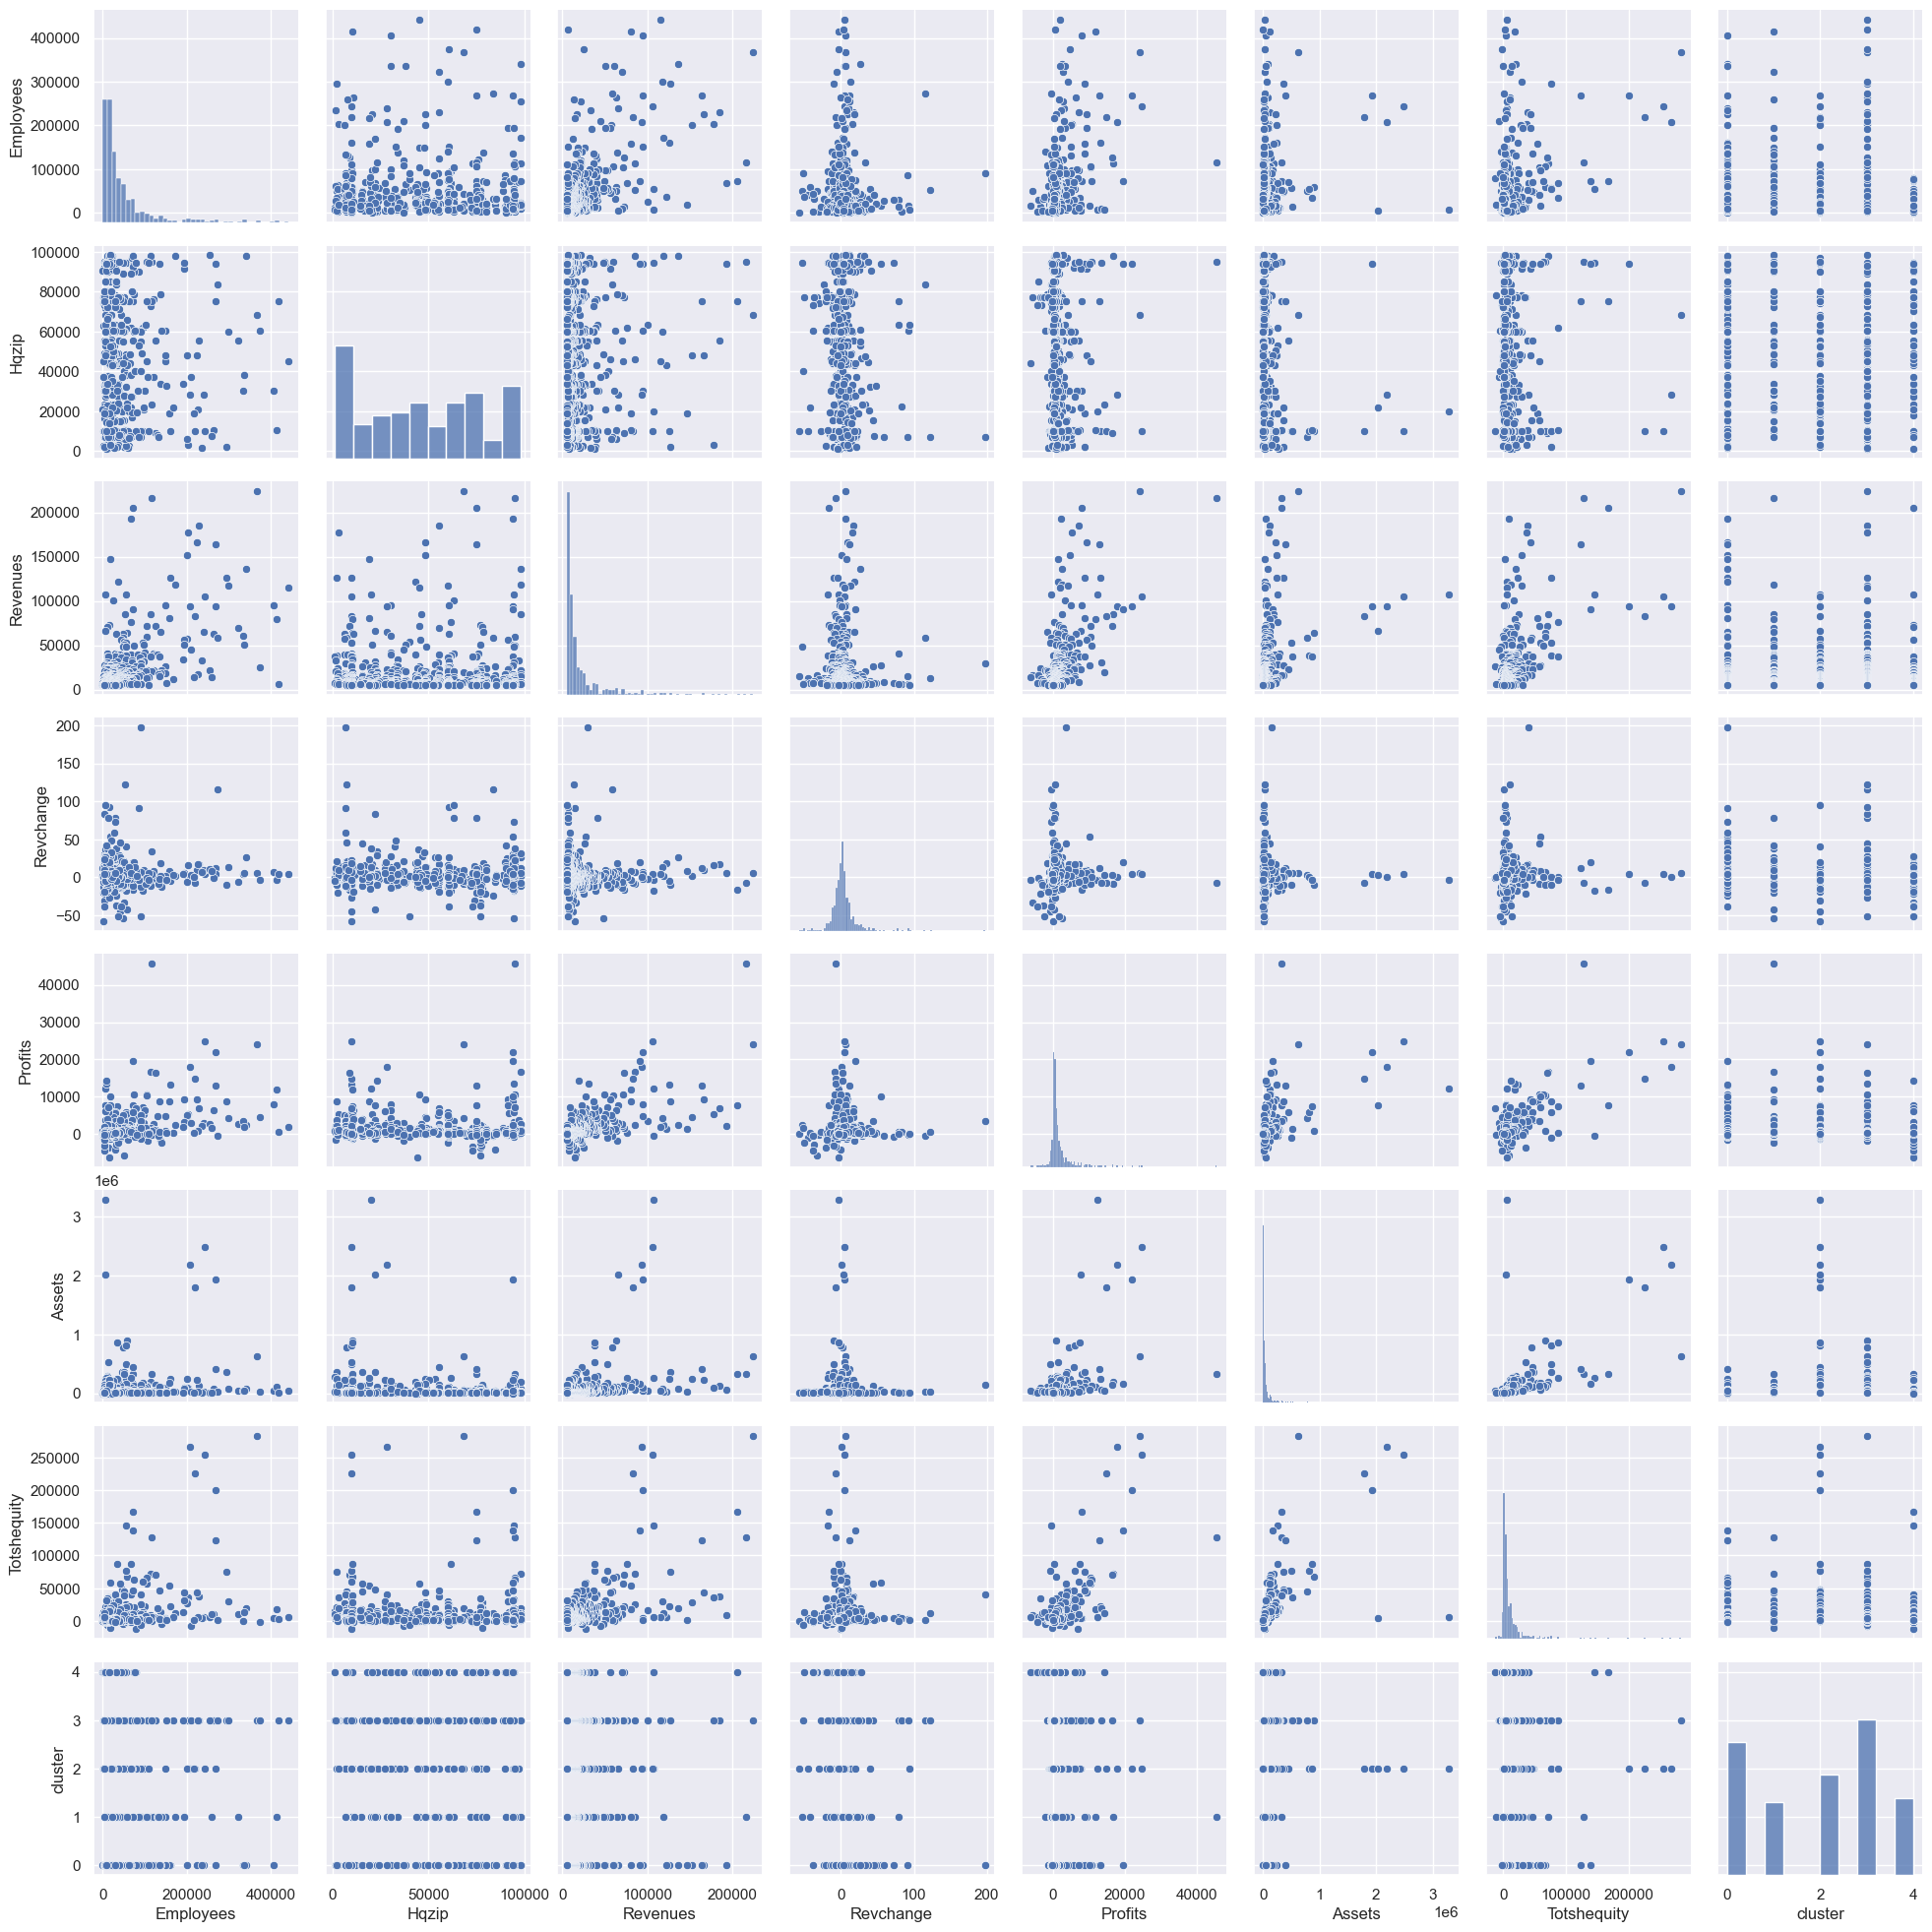

In [21]:
sns.pairplot(frt_500)

In [22]:
# Pass train and test thru feature engg pipeline
train_scaler = StandardScaler()
train_df = feature_engg_chain(X_train , y_train , train_scaler)
X_train_df = train_df[[col for col in train_df if col!='Revenues']]
y_train_df =train_df.Revenues

test_scaler = StandardScaler()
test_df = feature_engg_chain(X_test , y_test , test_scaler)
X_test_df = test_df[[col for col in test_df if col!='Revenues']]
y_test_df =test_df.Revenues

In [23]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_df.drop('industry',axis = 1).columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train_df.drop('industry',axis = 1).values, i)
                          for i in range(len(X_train_df.drop('industry',axis = 1).columns))]

vif_data

,feature,VIF
0,Employees,1.107303
1,Revchange,1.056591
2,Prftchange,1.018266
3,Assets,1.101016
4,cluster,1.279129
5,lat,1.091452
6,long,1.153139
7,Profits_per_asset,1.161500
8,Totshequity_per_asset,1.109326
9,sector,1.188361


Linear Regression

In [24]:
# OLS - all vars
X_train_c = sm.add_constant(X_train_df.drop('industry',axis = 1))
X_test_c = sm.add_constant(X_test_df.drop('industry',axis = 1))

model = sm.OLS(y_train_df,X_train_c)
res = model.fit()
print(res.summary())
# Not a great model. Let's drop some features

                            OLS Regression Results                            
Dep. Variable:               Revenues   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     24.88
Date:                Wed, 07 Dec 2022   Prob (F-statistic):           3.88e-35
Time:                        10:29:54   Log-Likelihood:                -57.434
No. Observations:                 349   AIC:                             136.9
Df Residuals:                     338   BIC:                             179.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     4.10

In [25]:
y_pred = res.predict(X_test_c)

In [26]:
mse = np.sqrt(np.sum((10**(y_pred) - 10**(y_test_df))**2))
mape = np.mean(abs((10**(y_pred) - 10**(y_test_df))/10**(y_test_df)))

mse , mape

(395086.43452941446, 0.5762270404768683)

In [27]:
# OLS - restricted vars
X_train_c = sm.add_constant(X_train_df[['Employees','Assets']])
X_test_c = sm.add_constant(X_test_df[['Employees','Assets']])

model = sm.OLS(y_train_df,X_train_c)
res = model.fit()
print(res.summary())
# Not a great model. Let's drop some features

                            OLS Regression Results                            
Dep. Variable:               Revenues   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     118.7
Date:                Wed, 07 Dec 2022   Prob (F-statistic):           5.65e-40
Time:                        10:29:55   Log-Likelihood:                -62.547
No. Observations:                 349   AIC:                             131.1
Df Residuals:                     346   BIC:                             142.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1642      0.016    267.591      0.0

In [28]:
y_pred = res.predict(X_test_c)

In [29]:
mse = np.sqrt(np.sum((10**(y_pred) - 10**(y_test_df))**2))
mape = np.mean(abs((10**(y_pred) - 10**(y_test_df))/10**(y_test_df)))

mse , mape

(369610.3853898012, 0.5793458330857575)

ElasticNet

In [30]:
# Ridge
for alpha in [0.0001 , 0.001 , 0.01 , 0.1 , 0.5 , 1.0 , 1.5 , 2.0 , 20 ]:
    regr = Ridge(alpha=alpha)
    regr.fit(X_train_df, y_train_df)
    # print(regr.coef_)
    # print(regr.intercept_)
    y_pred = 10**(regr.predict(X_test_df))
    print(f'MAPE for alpha = {alpha} -> {mean_absolute_percentage_error(y_pred , y_test)}')

MAPE for alpha = 0.0001 -> 0.6056717195575293
MAPE for alpha = 0.001 -> 0.6056721314389579
MAPE for alpha = 0.01 -> 0.6056762501950953
MAPE for alpha = 0.1 -> 0.605717431943587
MAPE for alpha = 0.5 -> 0.6059003342244358
MAPE for alpha = 1.0 -> 0.6061286695720023
MAPE for alpha = 1.5 -> 0.6063566810235498
MAPE for alpha = 2.0 -> 0.6065843697476048
MAPE for alpha = 20 -> 0.6151335836118028


In [31]:
# LASSO

for alpha in [0.0001 , 0.001 , 0.01 , 0.1 , 0.5 , 1.0 , 1.5 , 2.0 , 20 ]:
    regr = Lasso(alpha=alpha)
    regr.fit(X_train_df, y_train_df)
    # print(regr.coef_)
    # print(regr.intercept_)
    y_pred = 10**(regr.predict(X_test_df))
    print(f'MAPE for alpha = {alpha} -> {mean_absolute_percentage_error(y_pred , y_test)}')

MAPE for alpha = 0.0001 -> 0.6057809846593861
MAPE for alpha = 0.001 -> 0.6068012048041513
MAPE for alpha = 0.01 -> 0.6185371159227564
MAPE for alpha = 0.1 -> 0.7757455366281848
MAPE for alpha = 0.5 -> 1.086213652420356
MAPE for alpha = 1.0 -> 1.086213652420356
MAPE for alpha = 1.5 -> 1.086213652420356
MAPE for alpha = 2.0 -> 1.086213652420356
MAPE for alpha = 20 -> 1.086213652420356


Polynomial Regression

In [32]:
poly = PolynomialFeatures(degree = 3)
X_train_poly_fit = poly.fit_transform(X_train_df[['Employees','Assets','long']])

In [33]:
# The first alpha essentially reverts this back to simple unregularized lin reg
alpha = [0, 0.0001 , 0.1 , 1 , 5]
l1_ratio = [0, 0.001 , 0.01 , 0.1 , 0.25 ]

for res in itertools.product(alpha,l1_ratio):
    regr = ElasticNet(alpha=res[0], l1_ratio=res[1], fit_intercept=True, random_state = SEED)
    regr.fit(pd.DataFrame(X_train_poly_fit), y_train_df)
    y_pred = 10**(regr.predict(X_test_poly_fit := poly.fit_transform(X_test_df[['Employees','Assets','long']])))
    print(f'MAPE for alpha = {res} -> {mean_absolute_percentage_error(y_pred , y_test)}')

MAPE for alpha = (0, 0) -> 0.5363138277502302
MAPE for alpha = (0, 0.001) -> 0.5363138277502302
MAPE for alpha = (0, 0.01) -> 0.5363138277502302
MAPE for alpha = (0, 0.1) -> 0.5363138277502302
MAPE for alpha = (0, 0.25) -> 0.5363138277502302
MAPE for alpha = (0.0001, 0) -> 0.5301379248593681
MAPE for alpha = (0.0001, 0.001) -> 0.5301290352520479
MAPE for alpha = (0.0001, 0.01) -> 0.5300490791893899
MAPE for alpha = (0.0001, 0.1) -> 0.5292516096181955
MAPE for alpha = (0.0001, 0.25) -> 0.5279324967578147
MAPE for alpha = (0.1, 0) -> 0.55481586312789
MAPE for alpha = (0.1, 0.001) -> 0.5550626917595575
MAPE for alpha = (0.1, 0.01) -> 0.5569777912945821
MAPE for alpha = (0.1, 0.1) -> 0.5790058730059403
MAPE for alpha = (0.1, 0.25) -> 0.6175408322335947
MAPE for alpha = (1, 0) -> 0.7121622837238226
MAPE for alpha = (1, 0.001) -> 0.7134260814672208
MAPE for alpha = (1, 0.01) -> 0.7249316206787725
MAPE for alpha = (1, 0.1) -> 0.8660407929794026
MAPE for alpha = (1, 0.25) -> 0.9067305192078212

MLP

In [34]:
hidden_layers = [20,50,100,500,1000]
alpha=[0.01 , 0.1 , 1.0]

# using a cartesian product of the hidden_layers and alphas
for res in itertools.product(hidden_layers , alpha):
    regr = MLPRegressor(
        hidden_layer_sizes=res[0], activation='relu', solver='lbfgs', alpha=res[1], random_state = SEED
    )

    regr_fit = regr.fit(X_train_df , y_train_df)

    y_pred = regr_fit.predict(X_test_df)

    # Inverse transforming before checking error
    print(f'MAPE for {res} -> {np.mean(abs((10**(y_pred) - 10**(y_test_df))/10**(y_test_df)))}')

MAPE for (20, 0.01) -> 0.5416235067261151
MAPE for (20, 0.1) -> 0.5522086143931972
MAPE for (20, 1.0) -> 0.5442415546501342
MAPE for (50, 0.01) -> 0.5104190327769899
MAPE for (50, 0.1) -> 0.517575972469722
MAPE for (50, 1.0) -> 0.5092684513784352
MAPE for (100, 0.01) -> 0.5128913419761182
MAPE for (100, 0.1) -> 0.4780845384753939
MAPE for (100, 1.0) -> 0.5109493356202709
MAPE for (500, 0.01) -> 0.49670993302951616
MAPE for (500, 0.1) -> 0.5083843942656165
MAPE for (500, 1.0) -> 0.4807617223697336
MAPE for (1000, 0.01) -> 0.5101819788618325
MAPE for (1000, 0.1) -> 0.500859313265374
MAPE for (1000, 1.0) -> 0.5087175985679594


Ensemble Models

In [35]:
# XGBoost
# https://machinelearningmastery.com/xgboost-for-regression/

n_estimators = [50,100,500,1000]
max_depth = [2,5,10,20]

for res in itertools.product(n_estimators , max_depth):
    model = XGBRegressor(n_estimators=res[0], max_depth=res[1], eta=0.05, subsample=0.7, colsample_bytree=0.5,random_state=SEED)

    # define model evaluation method
    cv = RepeatedKFold(n_splits=15, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X_train_df, y_train_df, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)

    # force scores to be positive
    scores = abs(scores)
    print(f'Mean MAE for {res}: {scores.mean()}, ({scores.std()})')

Mean MAE for (50, 2): 0.06848554464911723, (0.011042184704891121)
Mean MAE for (50, 5): 0.07029470333462819, (0.010588900045244532)
Mean MAE for (50, 10): 0.0711785152192474, (0.010474983011936705)
Mean MAE for (50, 20): 0.07118279507159388, (0.010445450154832)
Mean MAE for (100, 2): 0.04001483909166444, (0.006574312531209576)
Mean MAE for (100, 5): 0.038049634704066866, (0.006395832131401534)
Mean MAE for (100, 10): 0.03853908831496068, (0.0063827949232347836)
Mean MAE for (100, 20): 0.03843600038667687, (0.006130837359832847)
Mean MAE for (500, 2): 0.0353981024848276, (0.006029126536364844)
Mean MAE for (500, 5): 0.03603026556764386, (0.006056450892016757)
Mean MAE for (500, 10): 0.03816674181412408, (0.006126090117205482)
Mean MAE for (500, 20): 0.03823063751783915, (0.005907053244802147)
Mean MAE for (1000, 2): 0.03511386179018476, (0.005826972970881655)
Mean MAE for (1000, 5): 0.035980821519680635, (0.006041438159318292)
Mean MAE for (1000, 10): 0.03816547770319391, (0.00612573659

In [36]:
model.fit(X_train_df, y_train_df, )
# make a prediction
yhat = model.predict(X_test_df)

In [37]:
mean_absolute_percentage_error(10**yhat , 10**y_test_df)

0.440204312004859

In [38]:
# Random Forest

n_estimators = [50,100,500,1000]
max_depth = [2,5,10,20]


for res in itertools.product(n_estimators , max_depth):
    model = RandomForestRegressor(n_estimators=res[0], criterion='squared_error', max_depth=res[1], min_samples_split=2, min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, max_features=1.0, max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, 
    n_jobs=-1, warm_start=False, ccp_alpha=0.0, max_samples=None,random_state=SEED)

    # define model evaluation method
    cv = RepeatedKFold(n_splits=15, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X_train_df, y_train_df, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)

    # force scores to be positive
    scores = abs(scores)
    print(f'Mean MAE for {res}: {scores.mean()}, ({scores.std()})')

Mean MAE for (50, 2): 0.0442716539501822, (0.006804385810879838)
Mean MAE for (50, 5): 0.0388744024525273, (0.005969835510198965)
Mean MAE for (50, 10): 0.03787858572178813, (0.005964916893535351)
Mean MAE for (50, 20): 0.038161079800880536, (0.005881865363326539)
Mean MAE for (100, 2): 0.04433229521632116, (0.006847296741027604)
Mean MAE for (100, 5): 0.038641949359859, (0.006010535000377865)
Mean MAE for (100, 10): 0.03780671773629543, (0.005905887558853997)
Mean MAE for (100, 20): 0.037926827634039234, (0.005915107252875549)
Mean MAE for (500, 2): 0.04420725154732332, (0.006702465498763704)
Mean MAE for (500, 5): 0.038384241163531715, (0.0059006369052530165)
Mean MAE for (500, 10): 0.037495583484260006, (0.0060332236554034935)
Mean MAE for (500, 20): 0.0375577628428571, (0.005973161658648715)
Mean MAE for (1000, 2): 0.0441591483308713, (0.0066797716495535205)
Mean MAE for (1000, 5): 0.03835438261247723, (0.0059268687597191115)
Mean MAE for (1000, 10): 0.0375376749424037, (0.00601108

In [39]:
model = RandomForestRegressor(n_estimators=1000, criterion='squared_error', max_depth=20, min_samples_split=2, min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, max_features=1.0, max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, 
    n_jobs=-1, warm_start=False, ccp_alpha=0.0, max_samples=None,random_state=SEED)

model.fit(X_train_df, y_train_df, )
# make a prediction
yhat = model.predict(X_test_df)

mean_absolute_percentage_error(10**yhat , 10**y_test_df)

0.3964149601353525

In [40]:
pd.DataFrame(list(zip(X_train_df.columns , model.feature_importances_)), columns = ['features','importance'])

,features,importance
0,Employees,0.359325
1,Revchange,0.026788
2,Prftchange,0.027343
3,Assets,0.396330
4,cluster,0.007132
5,lat,0.037435
6,long,0.025507
7,Profits_per_asset,0.053174
8,Totshequity_per_asset,0.025657
9,sector,0.011359


### **CLASSIFICATION**

In [41]:
X_0 = frt_500[[col for col in frt_500 if col!="cluster"]]
y = frt_500['cluster']

In [42]:
scaler = StandardScaler()

data = X_0.copy()

data['Hqzip'] = data['Hqzip'].astype('str').str.zfill(5)
# 2. Prftchange shouldn't be an object - it is a float. However it needs to be preprocessed - there are some commas etc
try:
    data['Prftchange'] = data['Prftchange'].astype('float')
except:
    data['Prftchange'] = data['Prftchange'].apply(lambda x : x.replace(',',''))
data['Prftchange'] = data['Prftchange'].astype('float')
    
nomi = pgeocode.Nominatim('us')
data['lat'] = data['Hqzip'].apply(lambda x: nomi.query_postal_code(x).latitude)
data['long'] = data['Hqzip'].apply(lambda x: nomi.query_postal_code(x).longitude) 

num_cov = list(data.describe().columns)
cat_cov = list(data.describe(include = 'object').columns)

num_data = data.loc[: , num_cov]
cat_data = data.loc[: , cat_cov]

# cat_data also has some info in it that may be useful in predicting rev / clustering. Let's label encode them.
le_1 = LabelEncoder()
le_2 = LabelEncoder()

l_encoded_sector = le_1.fit_transform(cat_data.Sector)
l_encoded_industry = le_2.fit_transform(cat_data.Industry)

# Remove multicollinearity
num_data['Profits_per_asset'] = num_data['Profits']/num_data['Assets'] # profit per asset
num_data['Totshequity_per_asset'] = num_data['Totshequity']/num_data['Assets'] # Totshequity per asset
num_data.drop(['Profits' , 'Totshequity'] , axis = 1 , inplace = True)
    
# Scaling independent vars
num_data_sd = pd.DataFrame(scaler.fit_transform(num_data) , columns = num_data.columns)

# Adding sector and industry
X = pd.concat(
    [
        num_data_sd,
        pd.Series(l_encoded_sector,name='sector'),
        pd.Series(l_encoded_industry,name='industry'),
    ],
    axis = 1
)

In [43]:
X_train , X_test , y_train , y_test = train_test_split(X, y, test_size = 0.3, stratify=y)

In [44]:
clf = MLPClassifier(hidden_layer_sizes = 35,random_state = SEED)
clf.fit(X_train , y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_pred,y_test)

0.8666666666666667

In [46]:
hidden_layers = [20,35,50,100,500,1000]
alpha = [0.001 , 0.1 , 1.0 , 5.0]
for res in itertools.product(hidden_layers,alpha):
    clf = MLPClassifier(hidden_layer_sizes=res[0],alpha=res[1],random_state=SEED,verbose=0)

    clf.fit(X_train,y_train)

    cv_s = cross_val_score(clf , X_test , y_test , cv = 10)
    print(f'{res} -> {cv_s.mean() , cv_s.std()}')

(20, 0.001) -> (0.7133333333333334, 0.13349989596333858)
(20, 0.1) -> (0.7133333333333333, 0.12310790208412928)
(20, 1.0) -> (0.7066666666666667, 0.12719189352225943)
(20, 5.0) -> (0.66, 0.1443760521847181)
(35, 0.001) -> (0.7666666666666668, 0.14981470036162825)
(35, 0.1) -> (0.78, 0.14313940369055927)
(35, 1.0) -> (0.7733333333333332, 0.10832051206181283)
(35, 5.0) -> (0.7733333333333332, 0.10832051206181283)
(50, 0.001) -> (0.7333333333333333, 0.09888264649460886)
(50, 0.1) -> (0.7333333333333333, 0.13333333333333336)
(50, 1.0) -> (0.76, 0.10832051206181283)
(50, 5.0) -> (0.7933333333333333, 0.10519822558706335)
(100, 0.001) -> (0.8266666666666665, 0.12364824660660942)
(100, 0.1) -> (0.8133333333333332, 0.12927146286443544)
(100, 1.0) -> (0.8200000000000001, 0.1077032961426901)
(100, 5.0) -> (0.8400000000000001, 0.10413666234542207)
(500, 0.001) -> (0.8466666666666667, 0.08459051693633016)
(500, 0.1) -> (0.8466666666666667, 0.08459051693633016)
(500, 1.0) -> (0.8466666666666667, 0.1

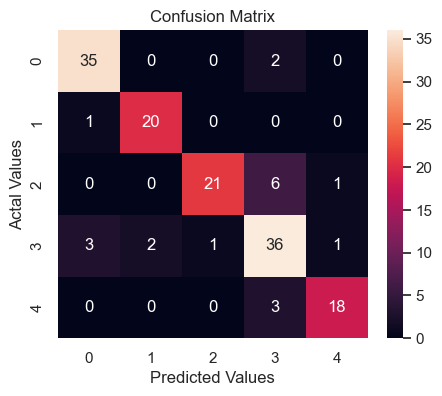

In [47]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test , y_pred)

cm_df = pd.DataFrame(cm , )

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()